# Conversion Rate Challenge


## Objective

This notebook aim's at optimizing conversion rates and making recommandations in order to improve revenues.
Based on the data of an anonymous firm, we will also make an algorithm to predict the probability of a conversion. 


The dataset is composed of 316,200 lines, we have access to features such as:
* country
* age
* new_user
* source
* total_pages_visited

and the target:
* converted 

In [83]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
from sklearn import metrics

data=pd.read_csv("s3://full-stack-bigdata-datasets/Machine Learning Supervisé/Projet Conversion Rate/conversion_data.csv")
display(data.head(5))
display(len(data))
display(data.describe(include = 'all'))
display(data.info())

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


316200

,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


None

In [46]:
print(data['country'].value_counts())

US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64


In [47]:
print(data['source'].value_counts())


Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64


In [284]:
data['converted'].value_counts()

0    306000
1     10200
Name: converted, dtype: int64

A few quick observations:

* the site is probably a US site, although it does have a large Chinese user base as well

* user base is pretty young

* conversion rate at around 3% is industry standard. It makes sense. It also shows that we're working with an imbalanced dataset  as we have 10,200 convertions against 306,000.!

* everything seems to make sense here except for max age 123 yrs! Let’s investigate it: 

In [286]:
data['age'].value_counts().sort_index(ascending = False).head(5)

123    1
111    1
79     1
77     1
73     1
Name: age, dtype: int64

In [49]:
display(data.loc[(data['age']== 123) | (data['age']== 111),:])
index = data.loc[(data['age']== 123) | (data['age']== 111),:].index

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


We could choose to consider these values as outliers because it's unlikely to be 123 or 111 years old but since we have not much '1' in converted values in comparison with the '0' we choose to keep it for the classifier, even if the age is strange the other values are still relevant

## Data Viz

### Big Picture

[]

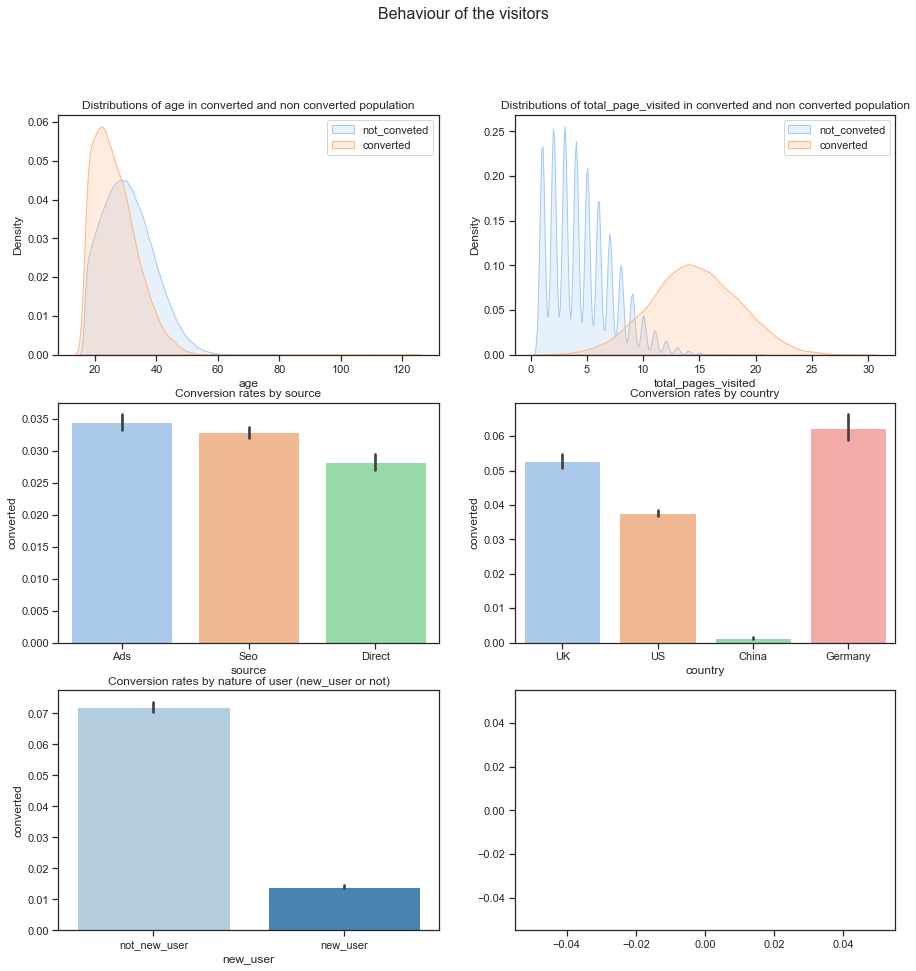

In [33]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(15,15))

#ax1 age
sns.kdeplot(data = data[data['converted'] == 0], x = 'age', shade = True, ax = ax1)
sns.kdeplot(data = data[data['converted'] == 1], x = 'age', shade = True, ax = ax1)
ax1.legend(['not_conveted', 'converted'])
#ax2 total_pages_visited
sns.kdeplot(data = data[data['converted'] == 0], x = 'total_pages_visited', shade = True, ax  = ax2)
sns.kdeplot(data = data[data['converted'] == 1], x = 'total_pages_visited', shade = True, ax  = ax2)
ax2.legend(['not_conveted', 'converted'])
#ax3 source
sns.barplot(data = data, x = 'source', y = 'converted', ax = ax3)
#ax4 country
sns.barplot(data = data, x = 'country', y = 'converted', ax = ax4)
#ax5 new_user
sns.barplot(data = data, x = 'new_user', y = 'converted', palette = 'Blues', ax = ax5)
ax5.set_xticklabels(['not_new_user', 'new_user'])

fig.suptitle('Behaviour of the visitors', fontsize = 16)
ax1.set_title('Distributions of age in converted and non converted population')
ax2.set_title('Distributions of total_page_visited in converted and non converted population')
ax3.set_title('Conversion rates by source')
ax4.set_title('Conversion rates by country')
ax5.set_title('Conversion rates by nature of user (new_user or not)')

plt.plot()

In [70]:
data[data['converted']==1]['source'].value_counts()

Seo       5100
Ads       3060
Direct    2040
Name: source, dtype: int64

Let's look closer to the behaviour of the visitors:

#### The Age:
The age seems to be a determinant factor as the majority of the buyers are between 17 and 30 while the website attracts people from 17 to 60.

*recommandation : Target adds towards people between 17 and 30*

#### The number of pages visited:
We can see that a lot of the visitors only visit few pages but the buyers seem to visit significantly more pages (between 10 and 15) but it seems like when they have to visit too much pages they don't buy the product.
also, we wonder ifeach line of the DataFrame corresponds to a unique user ?

*recommandation: Get the people to visit more pages but not too much (more target on people likely to buy and careful not to make the website too complicated to navigate in.* 

#### The countries:
Visitors are coming from The US, the UK, Germany and China. 
people are mainly coming from the US and the UK, the website is probably American ? 
Chinese are not likely to buy at all whereas German are (in proportion of visitors).
the likelihood to buy is followed buy the UK and the US visitors. Most of the buyers are coming from the US and the UK but again, they are note those who buy the most in proportion. 

*recommandation: Try to target more people from Germany as they are those who buy the most in proportion. 
translate the website in different langages so that it could attract other potential buyers. Try to have a better target on people coming from the UK and the US (with adds ?).* 

#### New users:
We would need more details about who is exactly called a new user but we can observe that 'old users' buy twice as much as new users but at the same time there is twice as much new user than old users (we will probably need to look more precisely what's going on with new users). 

*recommandation: it's important to keep in touch with new users as they are more likely to buy over time (notification push ? newsletter ? discounts ?). We also need to keep attracting new users as they are those who visit the most the website.* 

#### Source:
making Ads seems the most powerful tool to get people to buy, this is true in proportion However Seo does best in value (2100 vs 3060). We can try to invest more on adds (focus on age and on countries). 
we could use links on social medias ? adds on the TV ?


*recommandation: invest more on adds with a better targeting improve SEO efficiency.*

### What's going on with news users ?

In [34]:
data['new_user'].value_counts()


1    216744
0     99456
Name: new_user, dtype: int64

In [50]:
data[data['new_user']==1]['source'].value_counts()

Seo       106153
Ads        60849
Direct     49742
Name: source, dtype: int64

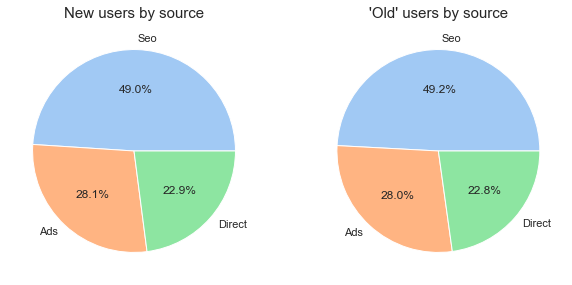

In [69]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.pie(data[data['new_user']==1]['source'].value_counts(), autopct='%1.1f%%', labels = ['Seo', 'Ads', 'Direct'])
ax1.set_title("New users by source", size =15, weight = 200)

ax2.pie(data[data['new_user']==0]['source'].value_counts(), autopct='%1.1f%%', labels = ['Seo', 'Ads', 'Direct'])
ax2.set_title("'Old' users by source", size =15, weight = 200)
plt.show()



<AxesSubplot:xlabel='country', ylabel='new_user'>

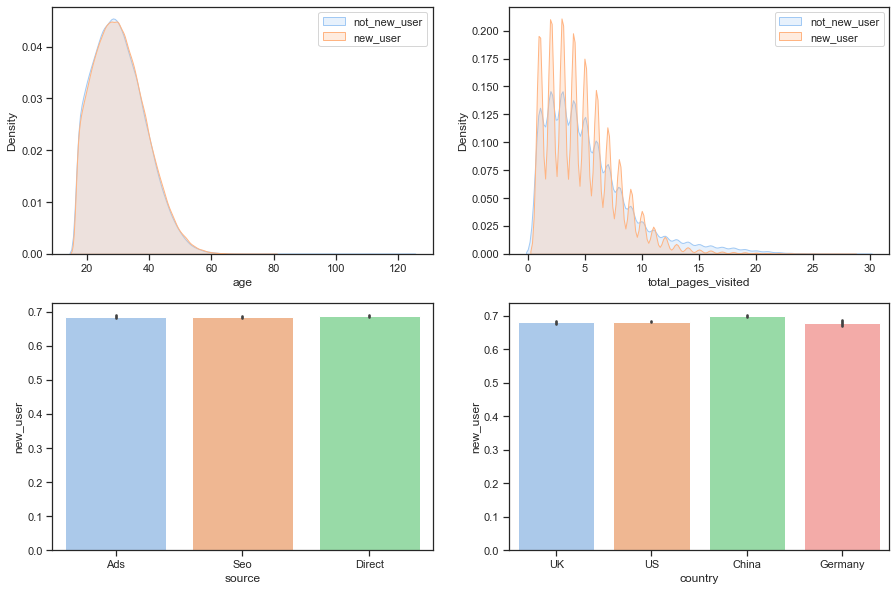

In [48]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))

sns.kdeplot(data = data[data['new_user'] == 0], x = 'age', shade = True, ax = ax1)
sns.kdeplot(data = data[data['new_user'] == 1], x = 'age', shade = True, ax = ax1)
ax1.legend(['not_new_user', 'new_user'])

sns.kdeplot(data = data[data['new_user'] == 0], x = 'total_pages_visited', shade = True, ax = ax2)
sns.kdeplot(data = data[data['new_user'] == 1], x = 'total_pages_visited', shade = True, ax = ax2)
ax2.legend(['not_new_user', 'new_user'])
plt.pie(data = data, x = 'source', y = 'new_user', ax = ax3)
sns.barplot(data = data, x = 'country', y = 'new_user', ax = ax4)



We can observe there's not really a target on a specific population as:
* the age distribution of new users is exactly the same as 'old users'
* new users are coming from ads, seo, and direct channels in the same proportion thant 'old users
* same observation for countries

## Logistic Regression

In [76]:
X = data[[c for c in data.columns if c != 'converted']] 
Y = data['converted']

X = X.values
Y = np.array(Y)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=19, stratify = Y)



In [77]:
# Create pipeline for numeric features
numeric_features = [1, 4] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])


# Create pipeline for categorical features
categorical_features = [0, 2, 3] # Positions of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])


# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test) 


In [78]:

# Train model
model = LogisticRegression(C=0.95, class_weight={0:0.684, 1:1}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model.fit(X_train, Y_train)


LogisticRegression(C=0.95, class_weight={0: 0.684, 1: 1})

In [79]:
# Predictions 
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

In [80]:

# Print scores
print("Accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("Accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))

Accuracy on training set :  0.9857017358914892
Accuracy on test set :  0.9873497786211258


Here we can see that the Accuracy is Excellent but it's only due to the fact that the data is imbalanced. There is way more 0(non buyers) than 1(buyers) which leads to a good accuracy because most of the time predicting 0 works. A more releveant metrics would be to use the F1 score.

In [81]:
print('f1 test :',f1_score(Y_test, Y_test_pred))
print('f1 train :',f1_score(Y_train, Y_train_pred))



f1 test : 0.7938144329896908
f1 train : 0.766886279003151


In [82]:
print(classification_report(y_true=Y_test, y_pred=model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     30600
           1       0.84      0.75      0.79      1020

    accuracy                           0.99     31620
   macro avg       0.91      0.88      0.89     31620
weighted avg       0.99      0.99      0.99     31620



this is the f1 score we get, let's analyze it further by looking at the precision and the recall as the formula of the f1 score is $ 2\times \frac{Precision \times Recall}{Precision + Recall}$


In [278]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score

precision = precision_recall_fscore_support(Y_test, Y_test_pred)[0][1]
recall = precision_recall_fscore_support(Y_test, Y_test_pred)[1][1]

print('Precision :',precision, 'which is the ability of the classifier not to label as positive a sample that is negative')
print('Recall :',recall, 'which is the ability of the classifier to find all the positive samples. ')


Precision : 0.8369565217391305 which is the ability of the classifier not to label as positive a sample that is negative
Recall : 0.7549019607843137 which is the ability of the classifier to find all the positive samples. 


we can see that it is more difficult for our classifier to correctly predict all the positive samples than to minimize misslabeling
of the positive samples, in other words when there is a 0 we are likely not to label it as 1, but when the is a 1 it's more difficult to label it as  1

[]

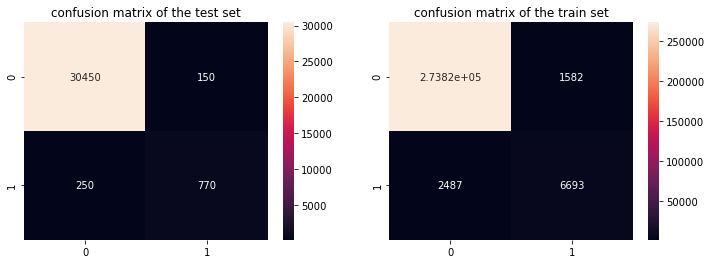

In [15]:


# Create confusion Matrix

cm_test = metrics.confusion_matrix(Y_test, Y_test_pred) 
cm_train = metrics.confusion_matrix(Y_train, Y_train_pred) 


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
sns.heatmap(cm_test, annot=True, ax = ax1, fmt=".5g" );
sns.heatmap(cm_train, annot=True, ax = ax2, fmt=".5g" );

ax1.set_title('confusion matrix of the test set')
ax2.set_title('confusion matrix of the train set')
plt.plot()

The confusion matrix confirms that it's more difficult to correctly labelize positive values than the negative ones. Now we would like to improve our f1 score. 

#### How to improve the F1 score ?


Let's list all the things we can work on to try improve the F1 score:

1. The Dataset
2. Data Cleaning + Feature Engineering
3. The parameters of the logistic function




1. The Dataset
We could rework the Dataset and reduce the amount of 0 so that we reduce the imbalance. But it also means there are less data to train on for the classifier so we choose to keep the Data as it is

2. The split of the Dataset
At this point we have already split the Data and made predictions. But how do we know that the original random split is the 
Best one to gather data from in order to build our logistic function ? Let's run a cross validation to see the variety of f1 scores that we could get.

In [199]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

scores_train = cross_val_score(model, X_train, Y_train, cv=10, scoring='f1')
#predictions = cross_val_predict(model, X_train, Y_train, cv = 10)

print(scores_train)
print('score min :',scores_train.min())
print('score max :',scores_train.max())


[0.75242996 0.75555556 0.75785797 0.77270098 0.76096998 0.77100115
 0.77390326 0.78547106 0.75486827 0.77841561]
score min : 0.7524299599771297
score max : 0.7854710556186153


3. The parameters of the logistic function

let's take a look at some graphs to understand several things





/opt/conda/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:894: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


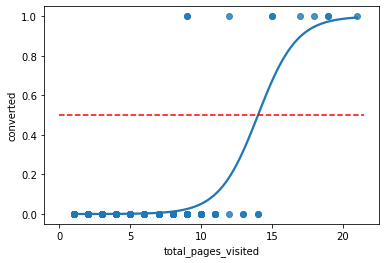

In [222]:
sns.regplot(x = data['total_pages_visited'][0:300], y = data['converted'][0:300], logistic = True)

# plot the no skill precision-recall curve
plt.plot([0, 21.5], [0.5, 0.5], linestyle='--', color = 'r')
plt.show()

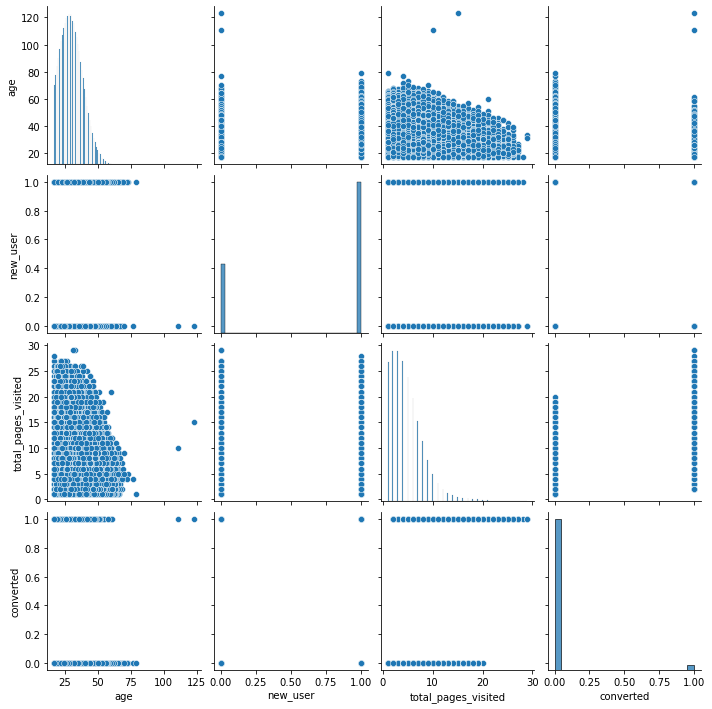

In [241]:
sns.pairplot(data)
plt.show()

let's take a look at the regplot to see the converted people given the total pages visited. In this example we understand that if we set as a decision factor that the threshold must be > 0.5 to be classified as positive, we are going to miss a lot of them. We would rather decrease this parameter to be able to spot more positive value even if we misslabelize some negative values

To do so we are going to make a grid search to find the best parameters to adjust the logistic function: 

In [200]:
# grid search class weights with logistic regression for imbalance classification
from numpy import mean
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# define grid
#cw_params = [{0:0.672,1:1}, {0:0.68,1:1}]
cw_params = [{0:i, 1:1} for i in np.arange(0.67, 0.69, 0.001)]
C_params = np.arange(0.9,1,0.01)
#C_params = [0.9]
param_grid = dict(class_weight = cw_params, C = C_params)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=69)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
# execute the grid search
grid_result = grid.fit(X_test, Y_test)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.791764 using {'C': 0.9500000000000001, 'class_weight': {0: 0.67, 1: 1}}
0.791476 (0.026249) with: {'C': 0.9, 'class_weight': {0: 0.67, 1: 1}}
0.791289 (0.025974) with: {'C': 0.9, 'class_weight': {0: 0.671, 1: 1}}
0.791289 (0.025974) with: {'C': 0.9, 'class_weight': {0: 0.672, 1: 1}}
0.791427 (0.025837) with: {'C': 0.9, 'class_weight': {0: 0.673, 1: 1}}
0.791228 (0.025509) with: {'C': 0.9, 'class_weight': {0: 0.674, 1: 1}}
0.791153 (0.025195) with: {'C': 0.9, 'class_weight': {0: 0.675, 1: 1}}
0.791153 (0.025195) with: {'C': 0.9, 'class_weight': {0: 0.676, 1: 1}}
0.791282 (0.025051) with: {'C': 0.9, 'class_weight': {0: 0.677, 1: 1}}
0.791282 (0.025051) with: {'C': 0.9, 'class_weight': {0: 0.678, 1: 1}}
0.791282 (0.025051) with: {'C': 0.9, 'class_weight': {0: 0.679, 1: 1}}
0.791282 (0.025051) with: {'C': 0.9, 'class_weight': {0: 0.68, 1: 1}}
0.791282 (0.025051) with: {'C': 0.9, 'class_weight': {0: 0.681, 1: 1}}
0.791282 (0.025051) with: {'C': 0.9, 'class_weight': {0: 0.682, 1: 1}}

In [212]:
print('f1 test :',f1_score(Y_test, Y_test_pred))
print('f1 train :',f1_score(Y_train, Y_train_pred))

f1 test : 0.7938144329896908
f1 train : 0.766886279003151


We have now a better f1 score, but the question is can we still improve the result ?
let's plot the precision - recall curve that gives every possible recall and precision values given a threshold 

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


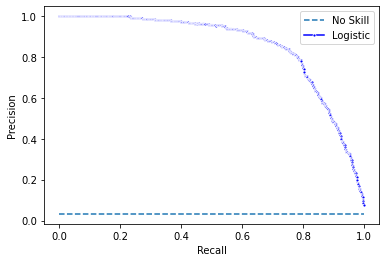

In [282]:
# example of a precision-recall curve for a predictive model
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve


yhat = model.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate the no skill line as the proportion of the positive class
no_skill = len(Y[Y==1]) / len(Y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(Y_test, pos_probs)
# plot the model precision-recall curve
#plt.plot(recall, precision, marker='.', label='Logistic')
sns.lineplot(recall, precision, marker ='.', label = 'Logistic', palette = 'pastel', color = 'b')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

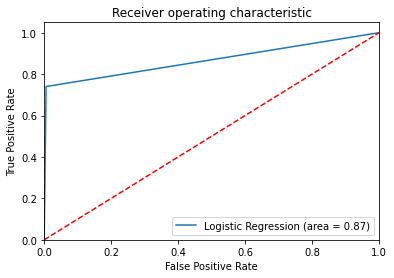

In [140]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, model.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()